In [ ]:
pip install ipympl

In [ ]:

# Imports
import numpy as np
%matplotlib widget
import matplotlib.pyplot as plt
import matplotlib
from collections import deque
import networkx as nx   # For drawing the graphs
import random

##### Citations #####
#
# networkx: https://networkx.org/documentation/stable/index.html 

In [ ]:
# Should NOT print 'module://matplotlib_inline.backend_inline'
# Should print 'module://ipympl.backend_nbagg'

print(matplotlib.get_backend())

module://ipympl.backend_nbagg


In [2]:

def gen_graph_adj(num_nodes, edge_probability):
    """
    Generate an undirected random graph with self-loops using an adjacency matrix.
    
    Parameters
    ----------
    num_nodes : int
        Number of nodes in the graph.
    edge_probability : float
        Probability of an edge between any pair of distinct nodes (i, j).
        
    Returns
    -------
    A : np.ndarray of shape (num_nodes, num_nodes)
        The adjacency matrix of the generated graph.
    """

    # 1. Generate an upper-triangular random matrix (excluding diagonal)
    rand_upper = np.random.rand(num_nodes, num_nodes)
    A = (rand_upper < edge_probability).astype(np.float32)

    # 2. Keep only the upper triangular part (i < j)
    A = np.triu(A, k=1)

    # 3. Mirror to make the graph undirected
    A = A + A.T

    # 4. Add self-loops (diagonal = 1)
    np.fill_diagonal(A, 1.0)

    return A

In [3]:
def adj_to_edge_list(A):
    """
    Convert an adjacency matrix into an edge list (u, v) format.
    Suitable for PyTorch Geometric.

    Parameters
    ----------
    A : np.ndarray of shape (N, N)
        Adjacency matrix of an undirected graph

    Returns
    -------
    edges : list of tuples
        List of (i, j) edges, including both directions for undirected edges.
    """
    num_nodes = A.shape[0]
    edges = []

    for i in range(num_nodes):
        for j in range(num_nodes):
            if A[i, j] != 0:
                edges.append((i, j))

    return edges


In [ ]:
def bfs(A, src):
    """
    Perform BFS on a graph given by adjacency matrix A, starting at node 'src'
    Returns list of distances from each node to the source
    
    Parameters
    ----------
    A : np.ndarray of shape (N, N)
        Adjacency matrix of an unweighted graph. Nonzero entries indicate edges.
    src : int
        Index of the source node.
    
    Returns
    -------
    distances : list of length N
        distances[i] = minimum number of hops from src to i.
        Unreachable nodes get distance = -1.
    """

    N = A.shape[0]
    distances = [-1] * N          # -1 means unreachable
    distances[src] = 0            # distance to itself is 0

    queue = deque([src])

    while queue:
        u = queue.popleft()

        # For all neighbors v of u (A[u, v] != 0)
        for v in range(N):
            if A[u, v] != 0 and distances[v] == -1:   # not visited yet
                distances[v] = distances[u] + 1
                queue.append(v)

    return distances

In [5]:
##### Citations #####
#
# mouse click event handler:    https://stackoverflow.com/questions/22052532/matplotlib-python-clickable-points 
# spring_layout                 https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
# circular_layout               https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.circular_layout.html
# kamada_kawai_layout           https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.kamada_kawai_layout.html
# draw_networkx_nodes:          https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx_nodes.html
# draw_networkx_edges:          https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx_edges.html
# draw_networkx_labels:         https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx_labels.html

def visualize_graph_bfs(A, layout="spring", k=1.0, base_color=(0.7, 0.7, 0.7), node_size=100):
    """
    Visualize BFS on an undirected graph given its adjacency matrix.
    When the graph is displayed, clicking on a src node will present BFS as a color gradient

    Parameters
    ----------
    A : np.ndarray of shape (N, N)
        Adjacency matrix (assumed undirected, with self-loops allowed).
    layout : str, optional
        Layout type: "spring", "circular", or "kamada_kawai".
    k: float, optional
        Optimal distance between nodes
    base_color: tuple, optional
        Color of base nodes
    node_size : int, optional
        Size of nodes in the plot.
    """
    
    # Build graph
    G = nx.from_numpy_array(A)
    N = G.number_of_nodes()

    # 2. Choose layout
    if layout == "spring":
        pos = nx.spring_layout(G, k=k)          # force-directed layout
    elif layout == "circular":
        pos = nx.circular_layout(G, k=k)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G, k=k)
    else:
        raise ValueError(f"Unknown layout: {layout}")
    
    # 3. Initial node colors
    node_colors = [base_color] * N

    # 3. Draw
    fig, ax = plt.subplots(figsize=(5, 5))
    # Draw nodes, edges, labels separately so we can update nodes later
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                                   node_size=node_size, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    plt.title("Random Graph")
    plt.axis("off")
    plt.tight_layout()

    def on_click(event):
        if event.inaxes is not ax:
            return
        
        click_xy = np.array([event.xdata, event.ydata])

        # Find nearest node
        #min_dist = float("inf")
        min_dist = 0.1
        nearest_node = None
        for n, (x, y) in pos.items():
            dist = np.linalg.norm(click_xy - np.array([x, y]))
            if dist < min_dist:
                min_dist = dist
                nearest_node = n

        # Reset graph colors if click on empty space
        if nearest_node is None:
            for i in range(N):
                node_colors[i] = base_color

            nodes.set_facecolor(node_colors)
            return

        distances = bfs(A, nearest_node)
        max_distance = max(distances)

        # Update node colors based on BFS
        for i in range(N):
            if(distances[i] == -1):
                node_colors[i] = base_color
            else:
                node_colors[i] = (1.0, 0.0 + (distances[i]) / (max_distance + 2), 0.0) # Red scale

        nodes.set_facecolor(node_colors)

        # Update title so we know something happened
        ax.set_title(f"Source node: {nearest_node}")

        # Redraw
        fig.canvas.draw_idle()

    cid = fig.canvas.mpl_connect('button_press_event', on_click)

    plt.show()

    

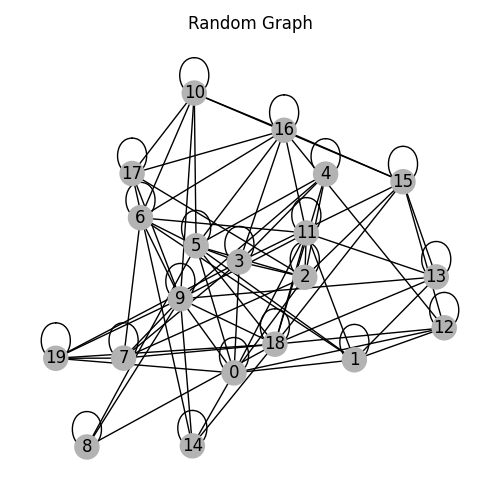

In [6]:
A = gen_graph_adj(20, 0.3)

# k is the optimal distance between nodes
visualize_graph_bfs(A, k=1.0, node_size=300)

In [ ]:
# == What we have done so far: ==
# Graph generator (Erdos-Renyi)
#   - No edge weights (Not needed for BFS)
# Graph visualizer
# BFS implementation 
#   - Given the ADJ matrix and a source node, computes distance from each node to the source
# BFS visualization
#   - Click a node to make it the source
# Simplest form of message passing with Identity 'Message' and 'Update' functions
#
# == Next: ==
# Create embedding function?
# Message passing with parameterized 'Message' and 'Update' functions
# Message passing with learnable 'Message' and 'Update' functions (MLPs)
# Weighted edges (sampled from [0.2, 1.0])
#   - Needed for B-F
# Update code for compatibility with weighted edges
# BFS with Learnable Message Passing 
#   - Figure out how to pass neural networks as arguments for MPNN
# Generate training graphs and store as .csv?
# Generate validation graphs and store
# Update code for compatibility with .csv data format
# ...


In [ ]:
def MP_primitive_step(A, h):
    """
    Perform a single step of basic message passing on a graph.

    Graph:
        - A is the adjacency matrix of shape (N, N).
        - h is the current node state / feature vector of shape (N,).

    Parameters
    ----------
    A : np.ndarray
        Adjacency matrix of shape (N, N). Nonzero A[i, j] indicates an edge j → i.
    h : np.ndarray
        Current node features of shape (N,). This is h^{(t)}.

    Returns
    -------
    h_next : np.ndarray
        Updated node features of shape (N,), i.e. h^{(t+1)}.
    """

    A = np.asarray(A)
    h = np.asarray(h)

    assert A.ndim == 2 and A.shape[0] == A.shape[1], "A must be square (N, N)"
    N = A.shape[0]
    assert h.shape[0] == N, "h must have shape (N,) matching A"

    # Ensure 1D shape (N,)
    h = h.reshape(N)

    h_next = np.zeros_like(h, dtype=float)

    # For each node i: aggregate messages from neighbors j
    for i in range(N):
        # Indeces j of neighbors where A[i, j] != 0
        neighbors = np.nonzero(A[i])[0]

        agg = 0.0
        for j in neighbors:
            # Message m_ji = φ(h_j) where φ is the identity matrix in this primitive version
            m_ji = h[j]
            agg += m_ji # Sum aggregation

        h_next[i] = agg

    return h_next


In [49]:
##### Citations #####
#
# mouse click event handler:    https://stackoverflow.com/questions/22052532/matplotlib-python-clickable-points 
# spring_layout                 https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
# circular_layout               https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.circular_layout.html
# kamada_kawai_layout           https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.kamada_kawai_layout.html
# draw_networkx_nodes:          https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx_nodes.html
# draw_networkx_edges:          https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx_edges.html
# draw_networkx_labels:         https://networkx.org/documentation/stable/reference/generated/networkx.drawing.nx_pylab.draw_networkx_labels.html

def visualize_primitive_MP(A, state_iterations, layout="spring", k=1.0, base_color=(0.7, 0.7, 0.7), reached_color=(0.3, 0.8, 1.0), node_size=100):
    """
    Visualize BFS on an undirected graph given its adjacency matrix.
    When the graph is displayed, clicking on a src node will present BFS as a color gradient

    Parameters
    ----------
    A : np.ndarray of shape (N, N)
        Adjacency matrix (assumed undirected, with self-loops allowed).
    state_iterations: list 
        Each state iteration which is used for animation
    layout : str, optional
        Layout type: "spring", "circular", or "kamada_kawai".
    k: float, optional
        Optimal distance between nodes
    base_color: tuple, optional
        Color of base nodes
    node_size : int, optional
        Size of nodes in the plot.
    """
    
    # Build graph
    G = nx.from_numpy_array(A)
    N = G.number_of_nodes()

    # 2. Choose layout
    if layout == "spring":
        pos = nx.spring_layout(G, k=k)          # force-directed layout
    elif layout == "circular":
        pos = nx.circular_layout(G, k=k)
    elif layout == "kamada_kawai":
        pos = nx.kamada_kawai_layout(G, k=k)
    else:
        raise ValueError(f"Unknown layout: {layout}")
    
    # 3. Initial node colors
    node_colors = [base_color] * N

    # 3. Draw
    fig, ax = plt.subplots(figsize=(5, 5))
    # Draw nodes, edges, labels separately so we can update nodes later
    nodes = nx.draw_networkx_nodes(G, pos, node_color=node_colors,
                                   node_size=node_size, ax=ax)
    nx.draw_networkx_edges(G, pos, ax=ax)
    nx.draw_networkx_labels(G, pos, ax=ax)

    plt.title("Random Graph")
    plt.axis("off")
    plt.tight_layout()

    current_iter = 0
    num_iters = len(state_iterations)

    reached_nodes = np.nonzero(state_iterations[current_iter])[0]
    for i in reached_nodes:
        node_colors[i] = reached_color

    nodes.set_facecolor(node_colors)
    fig.canvas.draw_idle()

    def on_click(event):
        if event.inaxes is not ax:
            return
        
        nonlocal current_iter
        nonlocal node_colors
        current_iter += 1
        
        if current_iter >= num_iters:
            node_colors = [base_color] * N
            current_iter = 0

        # Array of indeces for 'reached' nodes
        reached_nodes = np.nonzero(state_iterations[current_iter])[0]

        for i in reached_nodes:
            node_colors[i] = reached_color

        nodes.set_facecolor(node_colors)

        # Update title so we know something happened
        ax.set_title("Message Passing Primitive")

        # Redraw
        fig.canvas.draw_idle()

    cid = fig.canvas.mpl_connect('button_press_event', on_click)

    plt.show()

    

In [61]:
# Adjacency matrix initialization
num_nodes = 20
B = gen_graph_adj(num_nodes, 0.3)

src = random.randint(0, num_nodes - 1)

# This is the initial feature vector (the initial state)
h_0 = np.zeros(num_nodes)
h_0[src] = 1

# MP iterations
h_1 = MP_primitive_step(B, h_0)
h_2 = MP_primitive_step(B, h_1)
h_3 = MP_primitive_step(B, h_1)
h_4 = MP_primitive_step(B, h_1)

# MP iteration matrix
H = np.stack([h_0, h_1, h_2, h_3, h_4], axis=0)

C:\Users\stewa\AppData\Local\Temp\ipykernel_1560\3145812526.py:50: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(5, 5))


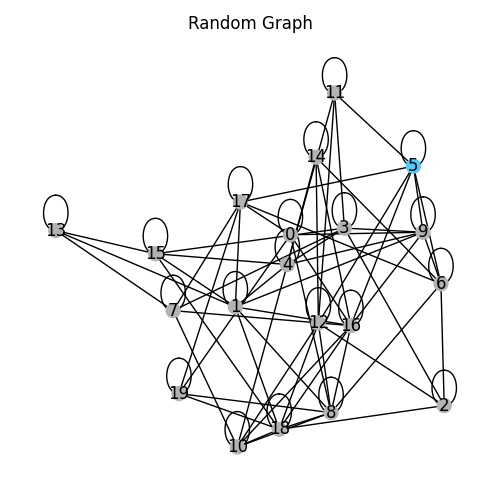

In [62]:
visualize_primitive_MP(B, H)